In [110]:
import numpy as np
import scipy
from scipy import sparse
import sys
sys.path.append("../../")
from src.funcs.lossfunction import LeastSquares
from src.funcs.regularizer import GL1
import src.utils as utils
import os
from scipy.io import savemat, loadmat
from copy import  deepcopy
from matplotlib import pyplot as plt

In [111]:
n, p = 128, 10
X = scipy.sparse.random(n, p, density=0.9, format='csr', random_state=0)
np.random.seed(0)
beta = np.random.randn(5, 1)
y = np.random.randn(n, 1)
weight_decay = 1e-5
f = LeastSquares(X, y, weight_decay=weight_decay)

In [112]:
num_of_groups = max(int(p * 0.5), 1)
group = utils.gen_group(p, num_of_groups)
Lip_path = f'./Lip.mat'
if os.path.exists(Lip_path):
    L = loadmat(Lip_path)["L"][0][0]
    print(f"loading Lipschitz constant from: {Lip_path}")
else:
    print(f"Compute Lip ...")
    L = utils.estimate_lipschitz(X, 'ls')
    savemat(Lip_path, {"L": L})
    print(f"save Lipschitz constant to: {Lip_path}")
r = GL1(penalty=0.01, groups=group)    

loading Lipschitz constant from: ./Lip.mat
Use fast initialization for the GL1 object


# ProxSVRG

In [121]:
num_epochs = 15
alphak = 0.5 / L
batchsize = 1
xk = np.zeros((p, 1))
if n % batchsize == 0:
    num_batches = n // batchsize
else:
    num_batches = n // batchsize + 1
x_seq = [xk]
full_idx = np.arange(n)
fxk = f.func(xk) 
gradfxk = f.gradient(xk)
rxk = r.func(xk)
inner_repeat = 1
print(f"Epoch:0, Fxk:{fxk+rxk:.4f}")
for epoch in range(num_epochs):
    x_minibatch = deepcopy(xk)
    for m in range(inner_repeat):
        np.random.seed(m+epoch)
        batchidx = np.random.permutation(full_idx)
        for i in range(num_batches):
            start_idx = i * batchsize
            end_idx = min(start_idx + batchsize, n)
            minibatch_idx = batchidx[start_idx:end_idx]
            _ = f.evaluate_function_value(x_minibatch, bias=0, idx=minibatch_idx)
            gradf_minibacth = f.gradient(x_minibatch, idx=minibatch_idx)
            # old grad
            _ = f.evaluate_function_value(xk, bias=0, idx=minibatch_idx)
            gradf_minibacth_old = f.gradient(xk, idx=minibatch_idx)
            vk = gradf_minibacth - gradf_minibacth_old + gradfxk
            x_minibatch, _, _ = r.compute_proximal_gradient_update(x_minibatch, alphak, vk)
            x_seq.append(x_minibatch)
    xk = deepcopy(x_minibatch)
    fxk = f.func(xk)
    gradfxk = f.gradient(xk)
    rxk = r.func(xk)
    print(f"Epoch:{epoch+1}, Fxk:{fxk+rxk:.4f}")

    

Epoch:0, Fxk:0.5067
Epoch:1, Fxk:0.4991
Epoch:2, Fxk:0.4952
Epoch:3, Fxk:0.4942
Epoch:4, Fxk:0.4939
Epoch:5, Fxk:0.4938
Epoch:6, Fxk:0.4938
Epoch:7, Fxk:0.4938
Epoch:8, Fxk:0.4938
Epoch:9, Fxk:0.4938
Epoch:10, Fxk:0.4938
Epoch:11, Fxk:0.4938
Epoch:12, Fxk:0.4938
Epoch:13, Fxk:0.4938
Epoch:14, Fxk:0.4938
Epoch:15, Fxk:0.4938


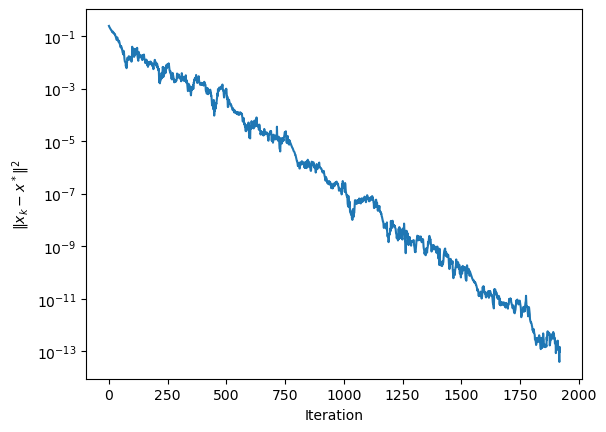

In [122]:
xsol = deepcopy(xk)
distance_seq = [np.linalg.norm(x - xsol)**2 for x in x_seq][:-1]
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_k-x^*\|^2$")
plt.semilogy(distance_seq)
# for i in [127*i*1 for i in range(16)]:
#     plt.vlines(i, 0, 1,linestyles='dashed',colors="red")
distance_seq_proxsvrg = distance_seq
xsol_proxsvrg = xsol


# ProxSAGA

In [123]:
num_epochs = 15
alphak = 0.5 / L
batchsize = 1
xk = np.zeros((p, 1))
if n % batchsize == 0:
    num_batches = n // batchsize
else:
    num_batches = n // batchsize + 1
x_seq = [xk]
full_idx = np.arange(n)
fxk = f.func(xk) 
temp, grad_table = f.gradient(xk, idx=None, return_table=True)
grad_table_mean = np.mean(grad_table, axis=1, keepdims=True)
rxk = r.func(xk)
print(f"Epoch:0, Fxk:{fxk+rxk:.4f}")
for epoch in range(num_epochs):
    np.random.seed(epoch)
    batchidx = np.random.permutation(full_idx)
    for i in range(num_batches):
        start_idx = i * batchsize
        end_idx = min(start_idx + batchsize, n)
        minibatch_idx = batchidx[start_idx:end_idx]
        _ = f.evaluate_function_value(xk, bias=0, idx=minibatch_idx)
        gradfxk_minibacth, gradfxk_minibacth_table = f.gradient(xk, idx=minibatch_idx, return_table=True)
        dk = (gradfxk_minibacth - np.mean(grad_table[:, minibatch_idx], axis=1, keepdims=True)) + grad_table_mean
        grad_table_mean = (grad_table_mean * n - np.sum(grad_table[:, minibatch_idx], keepdims=True,
                                   axis=1) + np.sum(gradfxk_minibacth_table, axis=1, keepdims=True)) / n
        grad_table[:, minibatch_idx] = gradfxk_minibacth_table                                   
        xkp1, _, _ = r.compute_proximal_gradient_update(xk, alphak, dk)
        xk = deepcopy(xkp1)
        x_seq.append(xk)
    fxk = f.func(xk)
    gradfxk = f.gradient(xk)
    rxk = r.func(xk)
    print(f"Epoch:{epoch+1}, Fxk:{fxk+rxk:.4f}")

    

Epoch:0, Fxk:0.5067
Epoch:1, Fxk:0.4967
Epoch:2, Fxk:0.4969
Epoch:3, Fxk:0.4947
Epoch:4, Fxk:0.4949
Epoch:5, Fxk:0.5001
Epoch:6, Fxk:0.4939
Epoch:7, Fxk:0.4939
Epoch:8, Fxk:0.4939
Epoch:9, Fxk:0.4939
Epoch:10, Fxk:0.4939
Epoch:11, Fxk:0.4938
Epoch:12, Fxk:0.4938
Epoch:13, Fxk:0.4939
Epoch:14, Fxk:0.4938
Epoch:15, Fxk:0.4938


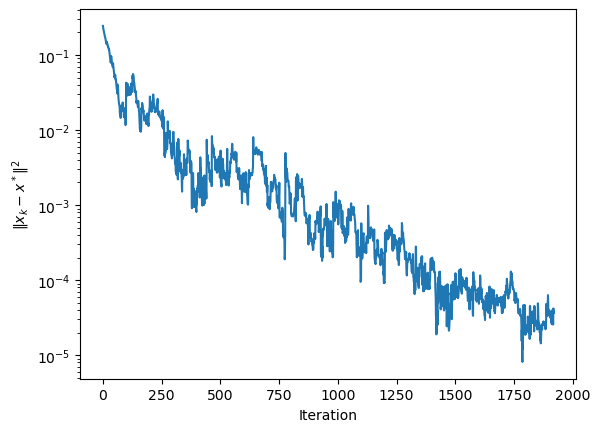

In [126]:
distance_seq = [np.linalg.norm(x - xsol_proxsvrg)**2 for x in x_seq]
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_k-x^*\|^2$")
plt.semilogy(distance_seq)
distance_seq_proxsaga = distance_seq


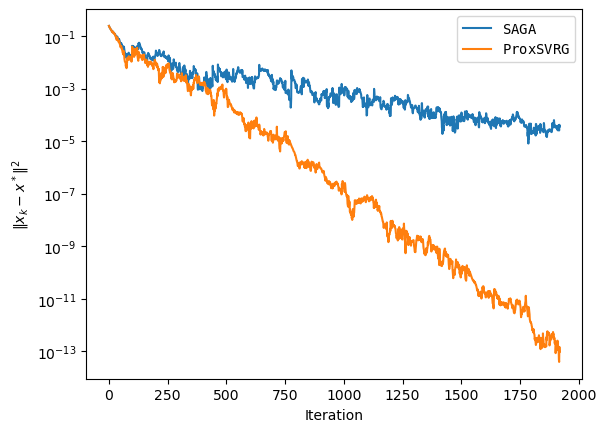

In [133]:
plt.semilogy(distance_seq_proxsaga, label=r"${\tt SAGA}$")
plt.semilogy(distance_seq_proxsvrg, label=r"${\tt ProxSVRG}$")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_k-x^*\|^2$")
plt.savefig("proxsvrg_saga.pdf", bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>